# <center> Stream Max Movie Selection Modeling and Recommender Project
### <center>ADS 505 Fall 2022</center>
**<center>Ivan Chavez</center>**
**<center>Azucena Faus</center>**
**<center>Sanjay Regi Philip</center>**
    
GitHub link: https://github.com/ivan-usd/business-repo

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import dmba
from pathlib import Path
import functools as ft
import string
import re
import spacy
import scikitplot as skplt
import plotly.graph_objs as go


from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.cluster import KMeans
from pandas.plotting import parallel_coordinates
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from plotly.offline import init_notebook_mode, plot, iplot
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


from dmba import regressionSummary
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import backward_elimination, forward_selection, stepwise_selection
from plotly.offline import init_notebook_mode, plot, iplot

from dmba import plotDecisionTree, classificationSummary, regressionSummary
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

from surprise import Dataset
from surprise import Reader
from surprise import KNNBasic

from dmba import gainsChart, liftChart
from ast import literal_eval

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

## Business Problem (Hypothetical):

*Business Status and Surveys:*

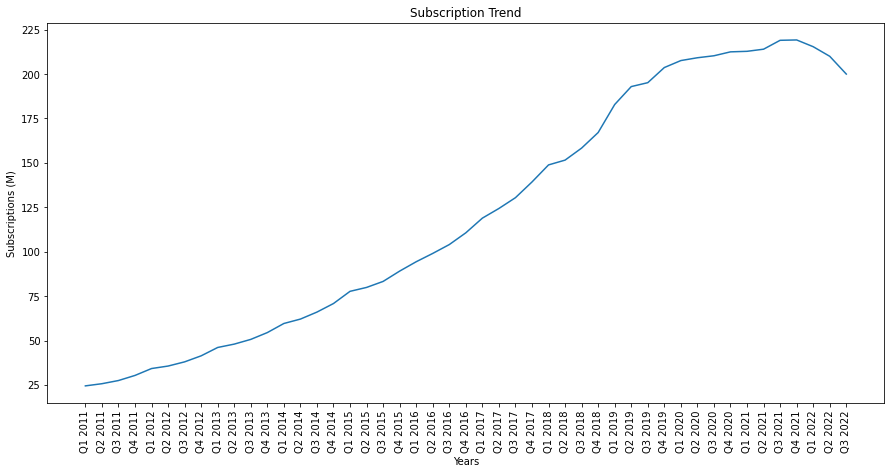

In [952]:
# Subscriber trends over time:

Monthly_Subscriptions=[24.480,25.7,27.49,
                       30.36,34.24,35.64,38,41.4,46.1,47.99,50.65,54.48,
                       59.6,62.08,66.02,70.84,77.7,79.9,83.28,89.09,94.36,
                       99.04,104.02,110.64,118.9,124.34,130.42,139.26,148.86,151.56,
                       158.33,167.09,182.86,192.95,195.15,203.67,207.6,209.18,210.3,
                       212.5,212.8,214,219,219.2,215.4,210,200]
#Yearly_Subscriptions=
months=['September 2021','October 2021',
       'November 2021','December 2021','January 2022','February 2022',
       'March 2022','April 2022','May 2022','June 2022',
       'July 2022','August 2022']
years_quarters=['Q1 2011','Q2 2011','Q3 2011','Q4 2011','Q1 2012',
       'Q2 2012','Q3 2012','Q4 2012','Q1 2013','Q2 2013','Q3 2013',
       'Q4 2013','Q1 2014','Q2 2014','Q3 2014','Q4 2014','Q1 2015',
       'Q2 2015','Q3 2015','Q4 2015','Q1 2016','Q2 2016','Q3 2016',
       'Q4 2016','Q1 2017','Q2 2017','Q3 2017','Q4 2017','Q1 2018',
       'Q2 2018','Q3 2018','Q4 2018','Q1 2019','Q2 2019','Q3 2019',
       'Q4 2019','Q1 2020','Q2 2020','Q3 2020','Q4 2020','Q1 2021',
       'Q2 2021','Q3 2021','Q4 2021','Q1 2022','Q2 2022','Q3 2022']
 

fig, ax = plt.subplots(figsize=(15,7))

plt.title('Subscription Trend')
ax.plot(years_quarters, Monthly_Subscriptions)
plt.xlabel('Years')
plt.xticks(rotation=90)
plt.ylabel('Subscriptions (M)')
#ax.plot(x, ratings_them)
plt.show()

*Last 3 Quarters we lost 19M subscribers*

### Customer Survey:

To find the possible reasons for subscriber loss

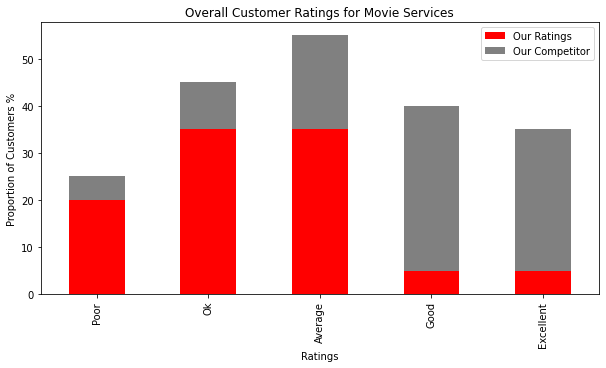

In [934]:
# Customer satisfaction:

x = [1, 2, 3, 4, 5]
ratings_us = [20, 35, 35, 5, 5]
ratings_them = [5, 10, 20, 35, 30]
Rating_Overall_Business = pd.DataFrame({'Our Ratings': [20, 35, 35, 5, 5],
                   'Our Competitor': [5, 10, 20, 35, 30]},
                  index=['Poor', 'Ok', 'Average', 'Good', 'Excellent'])

#fig, ax = plt.subplots()
Rating_Overall_Business.plot(kind='bar', stacked=True, color=['red', 'gray'],
                      figsize=(10,5))
 
# labels for x & y axis
plt.xlabel('Ratings')
plt.ylabel('Proportion of Customers %')
 
# title of plot
plt.title('Overall Customer Ratings for Movie Services')
plt.show()

*Upon comparing our ratings from customers to their perceived rating of our competitor, it is apparent there is a problem with our ratings*

### Noteworthy Specifics from Survey:

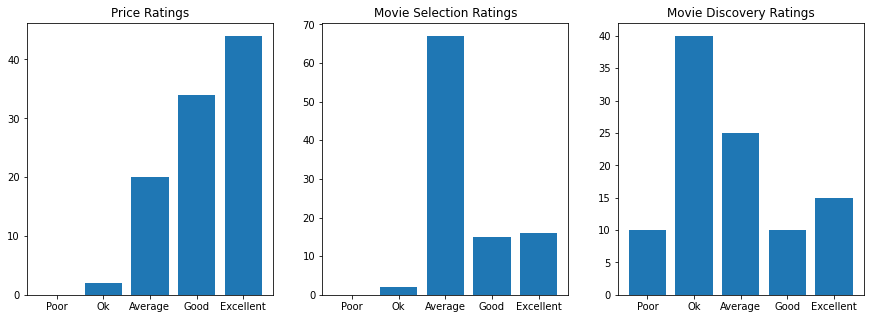

In [987]:
# Specific Survey results:

Rating_Importance = pd.DataFrame({'Price': [0, 2, 20, 34, 44],
                                 'Movie_Selection': [0, 2, 67, 15, 16],
                                 'Ease_of_finding_new_movies': [10, 40, 25, 10, 15]},
                  index=['Poor', 'Ok', 'Average', 'Good', 'Excellent'])

fig, ax = plt.subplots(1,3,figsize=(15,5))


#plt.show()
ax[0].bar(Rating_Importance.index,Rating_Importance.Price)
ax[1].bar(Rating_Importance.index,Rating_Importance.Movie_Selection)
ax[2].bar(Rating_Importance.index,Rating_Importance.Ease_of_finding_new_movies)


ax[0].title.set_text('Price Ratings') 
ax[1].title.set_text('Movie Selection Ratings') 
ax[2].title.set_text('Movie Discovery Ratings') 
ax=plt.show()

*The survey questions arose from comments in the lowest ratings and was collected over the same group of customers who sent the initial results. We can see our two areas of improvement are the Movie Selection and Movie Discovery.*

*Results:*

We see that we must improve our movie selection by choosing to add movies with higher predicted ratings than just the most recent. Also, we must have a way to help our customers discover new favorites without having to search the entire database of movies.

We will accomplish this through a movie ratings prediction algorithm that will be run on any new available selection of movies so we can only add those we are confident will be highly appreciated by our customer base, and a recommender system to use the current customer data ratings on movies already watched and recommend the top 3 or 4 movies that match with our customers' high-rated movies.

The data for movie rating prediction was based on 270,896 customer movie ratings and movie collections.
The data used for the recommender system was based on 671 customer ratings for movies.


----

## Feature Engineering:

In [2]:
keywords_df = pd.read_csv('keywords.csv')
links_df = pd.read_csv('links.csv')
credits_df = pd.read_csv('credits.csv')
movie_meta_df = pd.read_csv('movies_metadata.csv')
movie_meta_df.sample(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
44768,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,297736,tt4028876,en,Radiator,"A moving, blackly comic drama about the strain...",...,2014-10-15,0.0,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Radiator,False,8.1,4.0
6550,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,22200,tt0301684,en,Once Upon a Time in the Midlands,"Dek, a decent but somewhat dull man, enjoys a ...",...,2002-09-06,0.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Once Upon a Time in the Midlands,False,5.9,14.0
8242,False,"{'id': 8936, 'name': 'Bridget Jones Collection...",50000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,9801,tt0317198,en,Bridget Jones: The Edge of Reason,Bridget Jones is becoming uncomfortable in her...,...,2004-11-10,40203020.0,108.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Released,Same Bridget. Brand new diary.,Bridget Jones: The Edge of Reason,False,6.1,775.0
20292,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://keepthelightsonfilm.com/,84290,tt2011953,en,Keep the Lights On,An emotionally and sexually charged journey th...,...,2012-02-25,0.0,101.0,"[{'iso_639_1': 'da', 'name': 'Dansk'}, {'iso_6...",Released,NaN,Keep the Lights On,False,5.4,25.0
38495,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,97844,tt0093481,fr,Maladie d'amour,"Two physicians, one old and one young, fall in...",...,1987-09-30,0.0,122.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,NaN,Malady of Love,False,5.0,1.0


In [123]:
movie_meta_df.shape

(44838, 23)

In [105]:
ratings_df = pd.read_csv('ratings.csv')

In [4]:
ratings_small_df = pd.read_csv('ratings_small.csv')

In [106]:
ratings_df.tail()

,userId,movieId,rating,timestamp
26024284,270896,58559,5.0,1257031564
26024285,270896,60069,5.0,1257032032
26024286,270896,63082,4.5,1257031764
26024287,270896,64957,4.5,1257033990
26024288,270896,71878,2.0,1257031858


In [98]:
movie_meta_df.shape

(44838, 23)

In [99]:
ratings_df.shape
# 26M records, multiple
# ratings per 
# 27,086 users total

(26024289, 2)

In [100]:
ratings_small_df.shape
# about 100k records
# for 671 users with multiple
# movie ratings

(100004, 4)

In [107]:
ratings_small_df.tail()

,userId,movieId,rating,timestamp
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663
100003,671,6565,3.5,1074784724


In [6]:
# dropping corrupted rows
filtered_rows = movie_meta_df[movie_meta_df['vote_count'].isnull()].index
movie_meta_df=movie_meta_df.drop(index=filtered_rows)

movie_meta_df['id'] = movie_meta_df.id.astype('int')

In [7]:
# dropping adult rated movies
filtered_rows = movie_meta_df[movie_meta_df['adult']=='True'].index
movie_meta_df = movie_meta_df.drop(index=filtered_rows)

# dropping adult column no longer needed
movie_meta_df = movie_meta_df.drop(columns='adult')

In [8]:
# dropping movies that are not already Released
filtered_rows = movie_meta_df[movie_meta_df['status']!='Released'].index
movie_meta_df = movie_meta_df.drop(index=filtered_rows)

# dropping status column no longer needed
movie_meta_df = movie_meta_df.drop(columns='status')

In [9]:
movie_meta_df['video'].unique()

array([False, True], dtype=object)

In [10]:
# dropping movies that are not already Released
filtered_rows = movie_meta_df[movie_meta_df['video']==True].index
movie_meta_df = movie_meta_df.drop(index=filtered_rows)

# dropping status column no longer needed
movie_meta_df = movie_meta_df.drop(columns='video')

In [11]:
# removing appended imdb_id
movie_meta_df['imdb_id'] = movie_meta_df['imdb_id'].astype(str).str.replace('tt0', '')
movie_meta_df['imdb_id'] = movie_meta_df['imdb_id'].astype(str).str.replace('tt', '')
movie_meta_df.rename(columns={'imdb_id':'imdbId'}, inplace=True)

# merging meta and links df on imdb value
filtered_rows = movie_meta_df[movie_meta_df['imdbId'] == 'nan'].index
movie_meta_df = movie_meta_df.drop(index=filtered_rows)

movie_meta_df['imdbId'] = movie_meta_df['imdbId'].astype('int64')
movie_meta_df = pd.merge(movie_meta_df,links_df,on='imdbId')

### Cleaning JSON columns:

In [12]:
# merging datasets for text mining
dataframes = [keywords_df,credits_df,movie_meta_df]
text_df = ft.reduce(lambda left, right: pd.merge(left, right, on='id'), dataframes)

In [13]:
movies_df = pd.DataFrame(text_df[['movieId', 'keywords','cast', 'crew', 'genres',
                     'popularity', 'production_companies',
                     'production_countries','title', 'revenue']])

# dropping duplicates and missing values
movies_df.drop_duplicates(keep=False,inplace=True)
movies_df.dropna(inplace=True)

In [14]:
features = ['cast', 'crew', 'genres', 'keywords', 'production_companies', 
            'production_countries']

movies_df = movies_df.dropna(subset=features)

for feature in features:
    movies_df[feature] = movies_df[feature].apply(literal_eval)

In [15]:
## function to get name of director from the crew field
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

# get director
movies_df['director'] = movies_df['crew'].apply(get_director)
movies_df = movies_df.drop(columns='crew')

In [16]:
# Returns the list of top 3 elements for genres and keywords
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, 
        # return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [17]:
## function to get name of production company from the crew field
def get_names(x):
    for i in x:
        return i['name']
    return np.nan

# get production company names
movies_df['prod_company'] = movies_df['production_companies'].apply(get_names)
movies_df['prod_country'] = movies_df['production_countries'].apply(get_names)

movies_df = movies_df.drop(columns='production_companies')
movies_df = movies_df.drop(columns='production_countries')

In [18]:
features = ['cast', 'keywords', 'genres']

for feature in features:
    movies_df[feature] = movies_df[feature].apply(get_list)

In [19]:
filtered_rows = movies_df[movies_df['prod_country'] != 'United States of America'].index
movies_df = movies_df.drop(index=filtered_rows)
movies_df = movies_df.drop(columns='prod_country')

In [20]:
movies_df.head()

,movieId,keywords,cast,genres,popularity,title,revenue,director,prod_company
0,1,"[jealousy, toy, boy]","[Tom Hanks, Tim Allen, Don Rickles]","[Animation, Comedy, Family]",21.946943,Toy Story,373554033.0,John Lasseter,Pixar Animation Studios
1,2,"[board game, disappearance, based on children'...","[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[Adventure, Fantasy, Family]",17.015539,Jumanji,262797249.0,Joe Johnston,TriStar Pictures
2,3,"[fishing, best friend, duringcreditsstinger]","[Walter Matthau, Jack Lemmon, Ann-Margret]","[Romance, Comedy]",11.7129,Grumpier Old Men,0.0,Howard Deutch,Warner Bros.
3,4,"[based on novel, interracial relationship, sin...","[Whitney Houston, Angela Bassett, Loretta Devine]","[Comedy, Drama, Romance]",3.859495,Waiting to Exhale,81452156.0,Forest Whitaker,Twentieth Century Fox Film Corporation
4,5,"[baby, midlife crisis, confidence]","[Steve Martin, Diane Keaton, Martin Short]",[Comedy],8.387519,Father of the Bride Part II,76578911.0,Charles Shyer,Sandollar Productions


In [86]:
index_TWBalloon=movies_df['title']=='The White Balloon'
movies_df[index_TWBalloon]

,movieId,keywords,cast,genres,popularity,title,revenue,director,prod_company


In [87]:
index_TWBalloon2=movie_meta_df['title']=='The White Balloon'
movie_meta_df[index_TWBalloon2]

,belongs_to_collection,budget,genres,homepage,id,imdbId,original_language,original_title,overview,popularity,...,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count,movieId,tmdbId
79,NaN,0,"[{'id': 10751, 'name': 'Family'}, {'id': 18, '...",NaN,46785,112445,fa,بادکنک سفید,Several people try to take advantage of a litt...,1.196256,...,1995-01-01,0.0,85.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",NaN,The White Balloon,7.5,20.0,80,46785.0


-----

## EDA

In [992]:
len(ratings_df['userId'].unique())

270896

In [991]:
ratings_small_df['userId'].unique()

[1, 2, 3, 4, 5, ..., 667, 668, 669, 670, 671]
Length: 671
Categories (671, int64): [1, 2, 3, 4, ..., 668, 669, 670, 671]

In [525]:
ratings_small_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
ratings_small_df.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


### Average/Count relationships for Votes/Rates:

Text(0.5, 0.98, 'Relationship between Vote_Average and Vote_Count in Movie MetaData')

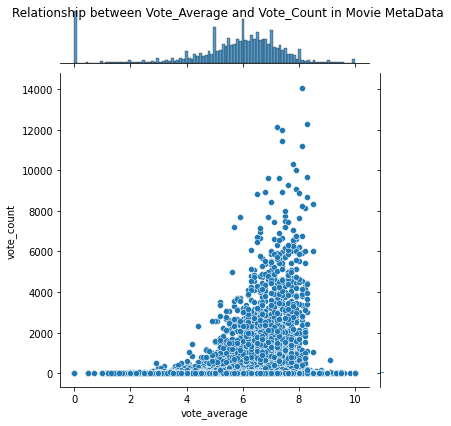

In [993]:
p=sns.jointplot(x='vote_average',y='vote_count', data=movie_meta_df)
p.fig.suptitle("Relationship between Vote_Average and Vote_Count in Movie MetaData")

In [529]:
# plot the rating avg vs rating count
# for our rating data:

ratings['rating_avg'] = pd.DataFrame(ratings_df.groupby('movieId')['rating'].mean())


ratings['rating_count'] = ratings_df.groupby('movieId')['rating'].count()
ratings.head()

,rating,number_of_ratings,rating_avg,rating_count
movieId,,,,
1,3.888157,66008,3.888157,66008
2,3.236953,26060,3.236953,26060
3,3.175550,15497,3.175550,15497
4,2.875713,2981,2.875713,2981
5,3.079565,15258,3.079565,15258


Text(0.5, 0.98, 'Relationship between Rating Average and Rating Count in Ratings Dataset')

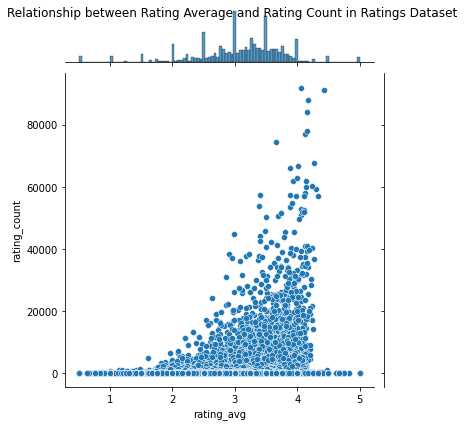

In [994]:
q=sns.jointplot(x='rating_avg', y='rating_count', data=ratings)
q.fig.suptitle("Relationship between Rating Average and Rating Count in Ratings Dataset")

*Results:*

We can see as the ratings increase, the number of people that rate the movie also increases. This is the case with both the overall movie metadata (movie_meta_df dataframe) and current customer ratings for those movies (from the ratings_df dataframe)

### Move Rating Distributions:

In [115]:
import plotly.io as pio
pio.renderers.default='notebook'

In [118]:
init_notebook_mode(connected=True)
data = ratings_small_df['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / 
                                                          ratings_small_df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution of Movie Ratings'.format(ratings_small_df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)

plot(fig)

'temp-plot.html'

In [119]:
# Number of ratings per movie:
data = ratings_small_df.groupby('movieId')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Movie (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
plot(fig)

'temp-plot.html'

In [671]:
rating_count = ratings_small_df.groupby('movieId')['rating'].count().reset_index()
rating_count_top10=rating_count.sort_values('rating', ascending=False)[:10]

In [672]:
rating_count_top10

,movieId,rating
321,356,341
266,296,324
284,318,311
525,593,304
232,260,291
427,480,274
2062,2571,259
0,1,247
472,527,244
522,589,237


### Top 10 movie ratings:

In [683]:
# Correlate movieId from ratings dataset
# to the imdbId in the links dataset:

top10=[]
top10_movieId=rating_count_top10['movieId'].reset_index()

for s in range(0,len(rating_count_top10)):
    index_links_top10=links_df['movieId']==top10_movieId['movieId'][s]

    top10_imdb=links_df['imdbId'][index_links_top10].astype('string')
#    top10_imdb_string=top10_imdb.values[0]
#    top10_imdb_movie= [f"tt0{top10_imdb_string}"]
    top10.append(top10_imdb.values[0])


# Find the movie title related to the
# newfound imdbId in the movie_meta_df
# dataset and add it to the top 10 rated
# movie titles:

top10_titles=[]

for i in range(0,len(top10)):
    
    index_movie_top10=movie_meta_df.loc[movie_meta_df['imdb_id'].str.contains(top10[i], 
                                                                              case=False)].index

    top10_title=movie_meta_df['title'][index_movie_top10]
    top10_title_string=top10_title.values[0]
    top10_titles.append(top10_title_string)

rating_count_top10['movie_title']=top10_titles



In [684]:
rating_count_top10

,movieId,rating,movie_title
321,356,341,Forrest Gump
266,296,324,Pulp Fiction
284,318,311,The Shawshank Redemption
525,593,304,The Silence of the Lambs
232,260,291,Star Wars
427,480,274,Jurassic Park
2062,2571,259,The Matrix
0,1,247,Toy Story
472,527,244,Schindler's List
522,589,237,Terminator 2: Judgment Day


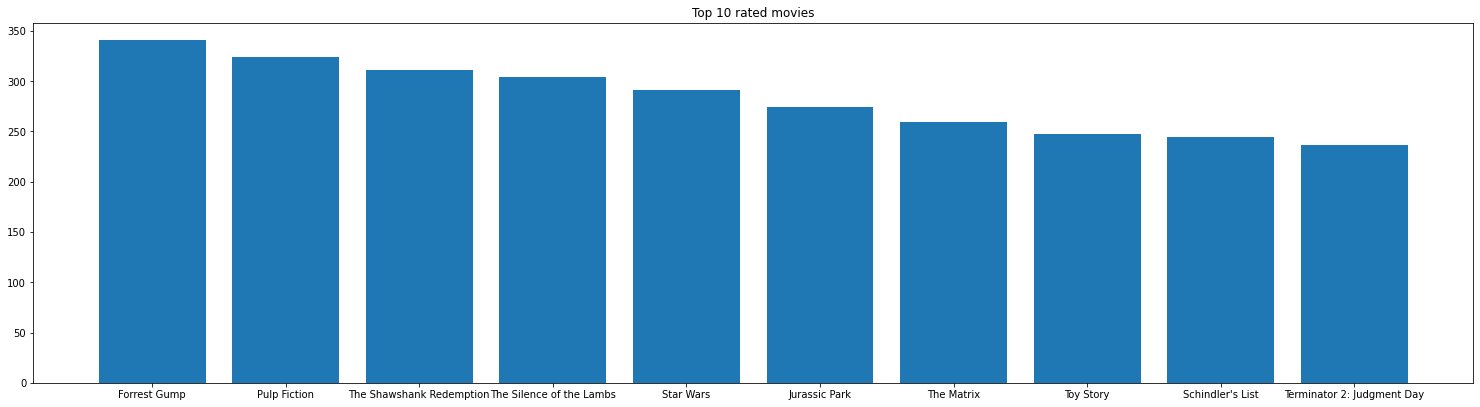

In [699]:

fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(rating_count_top10['movie_title'],rating_count_top10['rating'])
plt.title('Top 10 rated movies')
plt.show()

-------

## Recommender

### item-item collaborative filtering

Implementation as in page 365 of Data Mining for Business Analytics book

In [126]:
ratings_small_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [128]:
ratings_small_df.drop(columns='timestamp',inplace=True)

In [537]:
movie_mod=movie_meta_df[['movieId','vote_average']]

In [129]:
ratings_small_df['movieId']=ratings_small_df['movieId'].astype('category')
ratings_small_df['userId']=ratings_small_df['userId'].astype('category')

In [130]:
# Split data:
    
ratings_train, ratings_val = train_test_split(ratings_small_df,test_size=0.20, random_state = 2020)

#### Generate the collaborative filter model:

In [131]:
reader = Reader(rating_scale=(0, 6))
data = Dataset.load_from_df(ratings_train, reader)
trainset = data.build_full_trainset()

# compute cosine similarities between items
sim_options = {'name': 'cosine', 'user_based': False}  
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


### Predict top 4 on validation dataset:

In [144]:
predictions = algo.test(ratings_val)

top_n = get_top_n(predictions,n=4)

#top_n

In [132]:
# Automate and run on validation dataset:

movies = links_df.movieId
predictions_all2=pd.DataFrame()
    
for user in ratings_val['userId'].unique():

    predictions_user=pd.DataFrame(columns=['user','new_movie','predicted_rating'])
                                 
    for mov in movies:
        predictedUSER = algo.predict(user, mov).est 
    
        if predictedUSER >= 4:
            highest_rated_indexUSER = predictedUSER
            predictions_user.loc[len(predictions_user.index)] = [user, mov, 
                                                                 predictedUSER] 

    
    top_4_USER = predictions_user.sort_values('predicted_rating', ascending=False)[:4]
    predictions_all2=pd.concat([predictions_all2, top_4_USER], ignore_index=True, sort=False)

predictions_all2.columns = ['user','new_movie','predicted_rating']


In [146]:
# Automate and run on entire ratings_small_df

# Takes hours to run, was run and saved to .csv file
# in the GitHub repository

movies = links_df.movieId
predictions_all=pd.DataFrame()
    
for user in ratings_small_df['userId'].unique():

    predictions_user=pd.DataFrame(columns=['user','new_movie','predicted_rating'])
                                 
    for mov in movies:
        predictedUSER = algo.predict(user, mov).est 
    
        if predictedUSER >= 4:
            highest_rated_indexUSER = predictedUSER
            predictions_user.loc[len(predictions_user.index)] = [user, mov, 
                                                                 predictedUSER] 

    
    top_4_USER = predictions_user.sort_values('predicted_rating', ascending=False)[:4]
    predictions_all=pd.concat([predictions_all2, top_4_USER], ignore_index=True, sort=False)

predictions_all.columns = ['user','new_movie','predicted_rating']

* predictions_all is the predictions done on the entire dataset.
* prediction_all2 are the predictions done on only the validation dataset.

In [133]:
predictions_all2.shape

(2643, 3)

In [802]:
predictions_user

,user,new_movie,predicted_rating
0,671.0,1.0,4.100628
1,671.0,7.0,4.011990
2,671.0,9.0,4.099485
3,671.0,10.0,4.012579
4,671.0,17.0,4.110051
...,...,...,...
3972,671.0,161918.0,4.087500
3973,671.0,161944.0,4.375000
3974,671.0,162542.0,4.500000
3975,671.0,162672.0,4.500000


In [134]:
predictions_all2.tail()

,user,new_movie,predicted_rating
2638,638.0,8982.0,4.5
2639,76.0,43556.0,5.0
2640,76.0,42007.0,5.0
2641,76.0,582.0,5.0
2642,76.0,563.0,5.0


In [136]:
predictions_all2.to_csv('TopFour_MovieRecs.csv')

* Top4_MovieRecs.csv are all user movie recommendations
* TopFour_MovieRecs.csv are movie recommendations for validation dataset

In [812]:
predictions_all['new_movie']=predictions_all['new_movie'].astype('int')

In [843]:
predictions_all.iloc[48]

user                13.0
new_movie           1133
predicted_rating     5.0
Name: 48, dtype: object

In [844]:
index_curious=links_df['movieId']==1133
links_df[index_curious]

,movieId,imdbId,tmdbId
1110,1133,111357,NaN


In [846]:
movie_meta_df['imdb_id']=movie_meta_df['imdb_id'].astype('string')
index_weirdi=movie_meta_df.loc[movie_meta_df['imdb_id'].str.contains('11357', 
                                                                     case=False)].index
movie_meta_df['title'][index_weirdi]

27946    Kristin Lavransdatter
Name: title, dtype: object

In [850]:
# correcting erroneous data in links_df
links_df['imdbId'][index_curious]='11357'

In [847]:
index_curious2=links_df['imdbId']==11357
links_df[index_curious2]

,movieId,imdbId,tmdbId


In [851]:
links_df[index_curious]

,movieId,imdbId,tmdbId
1110,1133,11357,NaN


In [847]:
index_curious2=links_df['imdbId']==11357
links_df[index_curious2]

,movieId,imdbId,tmdbId


In [854]:
predictions_all.iloc[112]

user                29.0
new_movie           6776
predicted_rating     5.0
Name: 112, dtype: object

In [855]:
index_curious=links_df['movieId']==6776
links_df[index_curious]

,movieId,imdbId,tmdbId
6667,6776,282674,19666.0


In [881]:
movie_meta_df['imdb_id']=movie_meta_df['imdb_id'].astype('string')
index_weirdi=movie_meta_df.loc[movie_meta_df['imdb_id'].str.contains('22674', 
                                                                     case=False)].index
movie_meta_df['imdb_id'][index_weirdi]

9360     tt0322674
20870    tt1422674
31044    tt2267454
Name: imdb_id, dtype: string

In [884]:
index_curious2=links_df['imdbId']==422674
links_df[index_curious2]

,movieId,imdbId,tmdbId
9412,27639,322674,16132.0


### Add movie titles:

In [885]:
movie_meta_df['imdb_id']=movie_meta_df['imdb_id'].astype('string')

top4_movie_ALL=predictions_all['new_movie'].reset_index()
top4_titlesALL=[]

for ee in range(0,len(predictions_all)):
    #print(ee)
    index_links_top4ALL=links_df['movieId']==top4_movie_ALL['new_movie'][ee]

    top4_imdbALL=links_df['imdbId'][index_links_top4ALL].astype('string')
        
    top4ALL=top4_imdbALL.values[0]

    index_movie_top4ALL=movie_meta_df.loc[movie_meta_df['imdb_id'].str.contains(top4ALL, 
                                                                                case=False)].index

    if index_movie_top4ALL.empty:
        top4_titlesALL.append('NA')
    else:
        top4_titleALL=movie_meta_df['title'][index_movie_top4ALL]
        top4_title_stringALL=top4_titleALL.values[0]
        top4_titlesALL.append(top4_title_stringALL)


predictions_all['movie_title']=top4_titlesALL

In [140]:
movie_meta_df['imdbId']=movie_meta_df['imdbId'].astype('string')

top4_movie_ALL2=predictions_all2['new_movie'].reset_index()
top4_titlesALL2=[]

for ee in range(0,len(predictions_all2)):
    #print(ee)
    index_links_top4ALL2=links_df['movieId']==top4_movie_ALL2['new_movie'][ee]

    top4_imdbALL2=links_df['imdbId'][index_links_top4ALL2].astype('string')
        
    top4ALL2=top4_imdbALL2.values[0]

    index_movie_top4ALL2=movie_meta_df.loc[movie_meta_df['imdbId'].str.contains(top4ALL2, 
                                                                                case=False)].index

    if index_movie_top4ALL2.empty:
        top4_titlesALL2.append('NA')
    else:
        top4_titleALL2=movie_meta_df['title'][index_movie_top4ALL2]
        top4_title_stringALL2=top4_titleALL2.values[0]
        top4_titlesALL2.append(top4_title_stringALL2)


predictions_all2['movie_title']=top4_titlesALL2

*Save to a csv file:*

In [887]:
predictions_all.to_csv('Top4_MovieRecs_complete.csv')

In [141]:
predictions_all2.to_csv('TopFour_MovieRecs_validation.csv')

In [97]:
predictions_all_review = pd.read_csv('Top4_MovieRecs_complete.csv')
predictions_all_review.tail(12)

,Unnamed: 0,user,new_movie,predicted_rating,movie_title
2638,2638,669.0,162672,5.000000,Mohenjo Daro
2639,2639,669.0,62115,5.000000,Six Shooter
2640,2640,669.0,71438,5.000000,Still Walking
2641,2641,669.0,71180,5.000000,Padre Padrone
2642,2642,670.0,7574,5.000000,Maborosi
2643,2643,670.0,5236,5.000000,A Tale of Springtime
2644,2644,670.0,109483,5.000000,That Awkward Moment
2645,2645,670.0,4593,5.000000,Family Business
2646,2646,671.0,134783,4.833333,Entourage
2647,2647,671.0,39416,4.833333,Kids in America


In [142]:
predictions_all_review_valid = pd.read_csv('TopFour_MovieRecs_validation.csv')
predictions_all_review_valid.tail(12)

,Unnamed: 0,user,new_movie,predicted_rating,movie_title
2631,2631,112.0,64034.0,5.0,The Boy in the Striped Pyjamas
2632,2632,112.0,51086.0,5.0,The Number 23
2633,2633,112.0,128512.0,5.0,Paper Towns
2634,2634,112.0,93422.0,5.0,Starbuck
2635,2635,638.0,160590.0,4.5,Survive and Advance
2636,2636,638.0,8167.0,4.5,Captain Blood
2637,2637,638.0,26094.0,4.5,L'eclisse
2638,2638,638.0,8982.0,4.5,I Am David
2639,2639,76.0,43556.0,5.0,Annapolis
2640,2640,76.0,42007.0,5.0,Rumor Has It...


### Remove titles not found in links_df

#### Every user will have at least 3 recommendations, at maximum, 4

In [147]:
index_curious3=predictions_all2['movie_title']=='NA'
index_curious4=predictions_all2[index_curious3].index
predictions_complete_all2=predictions_all2.drop(index_curious4, axis=0)

In [148]:
predictions_complete_all2.to_csv('TopFour_MovieRecs_final_valid.csv')

In [896]:
index_curious3=predictions_all['movie_title']=='NA'
index_curious4=predictions_all[index_curious3].index
predictions_complete_all=predictions_all.drop(index_curious4, axis=0)

In [1006]:
predictions_complete_all.to_csv('Top4_MovieRecs_final.csv')

---

## Recommender Results (Hypothetical):

How was the recommender outputs received by users?

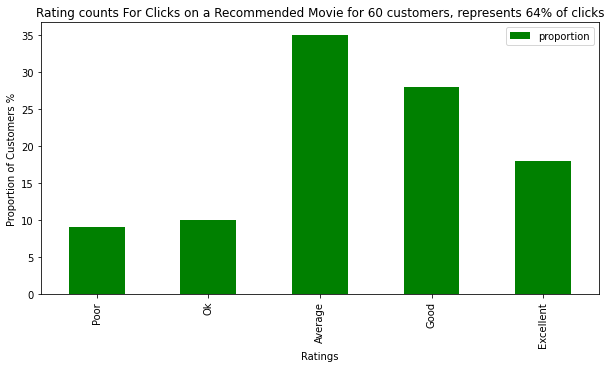

In [1043]:
# About Half of the validation set
# 60 customers selected for soft deployment
# of the recommdner system.

# Here are the results:

#x3 = 3*np.ones(35,1)
#x4 = 4*np.ones(28,1)
#x5 = 5*np.ones(18,1)
#x2 = 2*np.ones(10,1)
#x1 = np.ones(9,1)

no_clicks_recMovies = 180 #average of 3 per user
no_clicks_Wreviews = 115 #people rated less than avg of 2/3 clicks
#ratings_per_click=['x3','x4','x5','x2','x1']
Rating_Recommended_Clicks = pd.DataFrame({'proportion': [9, 10, 35, 28, 18]},
                  index=['Poor', 'Ok', 'Average', 'Good', 'Excellent'])

#fig, ax = plt.subplots()
Rating_Recommended_Clicks.plot(kind='bar', color=['green'],
                      figsize=(10,5))
 
# labels for x & y axis
plt.xlabel('Ratings')
plt.ylabel('Proportion of Customers %')
 
# title of plot
plt.title('Rating counts For Clicks on a Recommended Movie for 60 customers, represents 64% of clicks')
plt.show()

-----

## Data Pre-Processing:

### Use avg rating to fill for movies & prep modeling dataframe:

In [21]:
# averaging ratings and merging ratings to final dataframe on movie Id
ratings_df.drop(columns=['userId', 'timestamp'], inplace=True)
avg_ratings = round(ratings_df.groupby('movieId').mean(),2)
final_df = pd.merge(movies_df,avg_ratings,on='movieId')
final_df.rename(columns={'rating':'avg_rating'}, inplace=True)

# dropping null values
final_df = final_df.dropna()

# popularity clean up
final_df['popularity'] = final_df['popularity'].astype('float')
final_df['popularity'] = round(final_df['popularity'],2)

# reducing revenue to millions to mitigate large values
final_df['revenue_millions'] = round(final_df['revenue']/1000000, 3)
final_df = final_df.drop(columns='revenue')

### Export to csv to use for modeling:

In [23]:
final_df.to_csv('modeling_data.csv',index=False)

### Pre-Process for Modeling:

In [24]:
movies = pd.read_csv('modeling_data.csv')

features = ['keywords', 'cast', 'genres']

for feature in features:
    movies[feature] = movies[feature].apply(literal_eval)

In [25]:
movies['director'] = movies['director'].astype(str).str.replace('.', '')
movies['director'] = movies['director'].astype(str).str.replace(' ', '_')

movies['prod_company'] = movies['prod_company'].astype(str).str.replace('.', '')
movies['prod_company'] = movies['prod_company'].astype(str).str.replace(' ', '_')

In [26]:
movies['label'] = pd.cut(movies.avg_rating, bins=[0,3.4,5],labels=[0,1])

In [27]:
X = movies[['genres','cast','director','prod_company','popularity','revenue_millions']]
y = movies[['avg_rating','label','title']]

In [28]:
# creating dummies
genres_cat = X.genres.str.join('|').str.get_dummies().add_prefix('genres_')
X = pd.concat([X, genres_cat], axis=1)
X = X.drop(columns='genres')

In [29]:
# creating dummies
cast_cat = X.cast.str.join('|').str.get_dummies().add_prefix('cast_')
X = pd.concat([X, cast_cat], axis=1)
X = X.drop(columns='cast')

In [30]:
keyword_cat = X.director.str.get_dummies().add_prefix('director_')
X = pd.concat([X, keyword_cat], axis=1)
X = X.drop(columns='director')

In [31]:
keyword_cat = X.prod_company.str.get_dummies().add_prefix('prod_company_')
X = pd.concat([X, keyword_cat], axis=1)
X = X.drop(columns='prod_company')

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.20, random_state = 2022)

----

## Visualizations for Movie Characteristics:

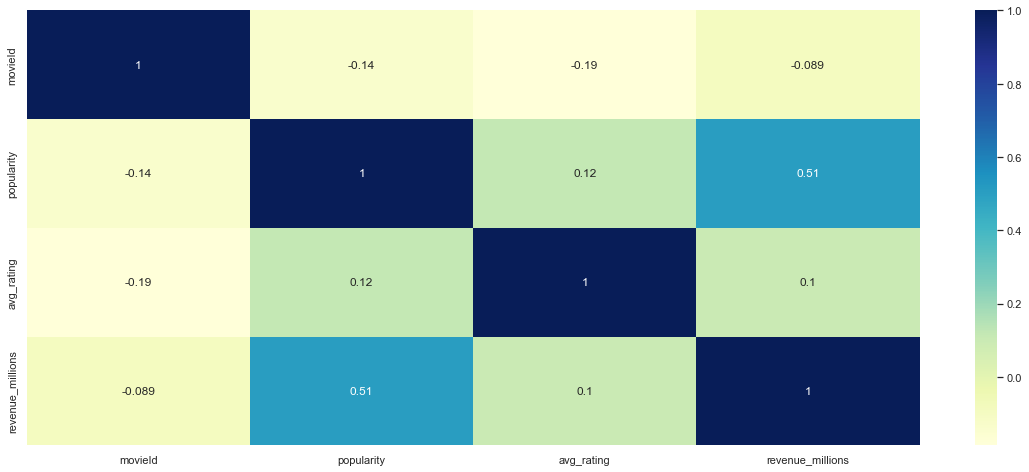

In [108]:
# plot the heatmap and annotation on it
#Correlation matrix 
corr_matrix_movies = movies.corr()
sns.set(rc = {'figure.figsize':(20,8)})
sns.heatmap(corr_matrix_movies, cmap="YlGnBu", annot=True)
plt.show()

*Results:*

There is a moderate correlation between popularity and revenue in millions, which is obvious. Otherwise, avg rating is not related to movieId, popularity or revenue in millions

In [48]:
filter_col = [col for col in X if col.startswith('genres')]

In [49]:
X[filter_col].columns

Index(['genres_Action', 'genres_Adventure', 'genres_Animation',
       'genres_Comedy', 'genres_Crime', 'genres_Documentary', 'genres_Drama',
       'genres_Family', 'genres_Fantasy', 'genres_Foreign', 'genres_History',
       'genres_Horror', 'genres_Music', 'genres_Mystery', 'genres_Romance',
       'genres_Science Fiction', 'genres_TV Movie', 'genres_Thriller',
       'genres_War', 'genres_Western'],
      dtype='object')

In [1049]:
X_genre_counts=X[filter_col].sum()


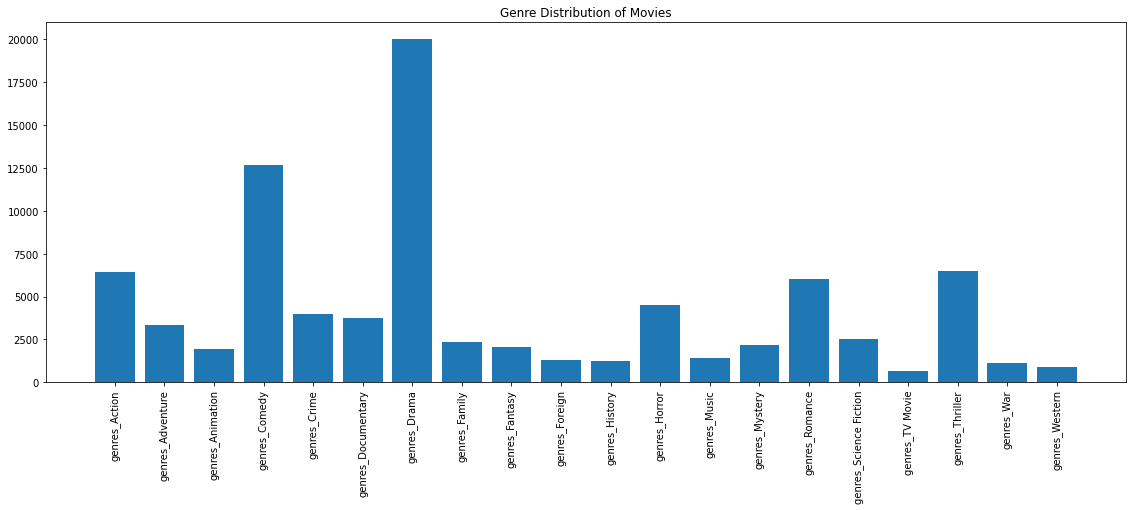

In [1056]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(X[filter_col].columns,X[filter_col].sum())
plt.title('Genre Distribution of Movies')
plt.xticks(rotation=90)
plt.show()

*Results:*

Drama and Comedy are the largest genre represented by our movie dataset.

In [37]:
filter_col_cast = [col for col in X if col.startswith('cast')]

In [38]:
X[filter_col_cast].columns

Index(['cast_\tRobert Osth', 'cast_ Larry Mullen Jr.',
       'cast_"Weird Al" Yankovic', 'cast_'Little Billy' Rhodes',
       'cast_50 Cent', 'cast_A Martinez', 'cast_A. Michael Baldwin',
       'cast_A.C. Abadie', 'cast_A.E. Anson', 'cast_A.J. Buckley',
       ...
       'cast_Élisabeth Vitali', 'cast_Óscar Jaenada', 'cast_Đơn Dương',
       'cast_Đỗ Thị Hải Yến', 'cast_Дэмиан Чапа', 'cast_Моррис Честнат',
       'cast_Патрик О’Нил', 'cast_Эрика Элениак', 'cast_پیمان معادی',
       'cast_杰森·莫玛'],
      dtype='object', length=15252)

In [43]:
cast_counts=X[filter_col_cast].sum()
cast_counts_df=pd.DataFrame(cast_counts,columns=['count'])

In [44]:
cast_counts_df.head()

,count
cast_\tRobert Osth,1
cast_ Larry Mullen Jr.,1
"cast_""Weird Al"" Yankovic",1
cast_'Little Billy' Rhodes,1
cast_50 Cent,9


In [83]:
cast_top20=cast_counts_df.sort_values('count', ascending=False)[:20]

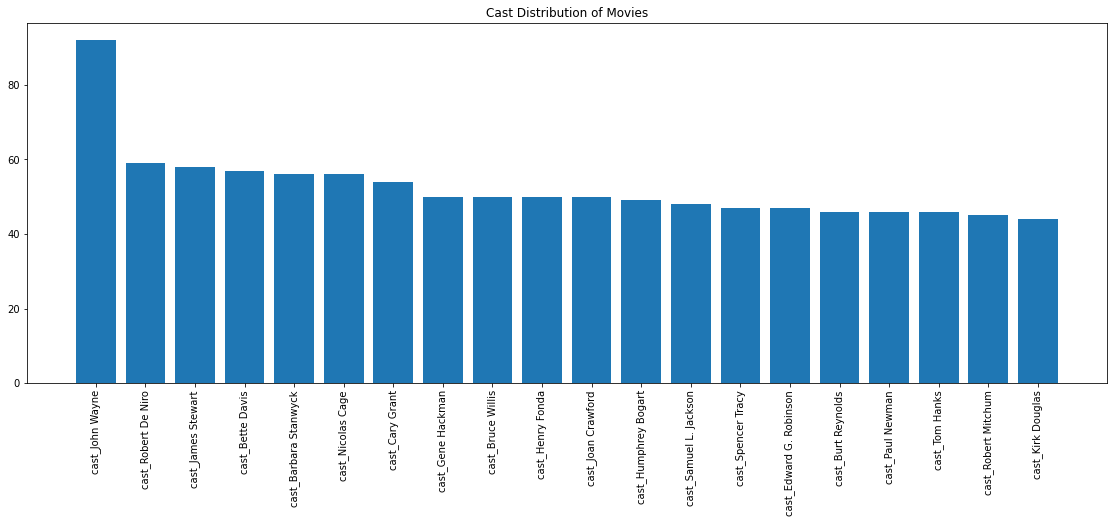

In [85]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(cast_top20.index,cast_top20['count'])
plt.title('Cast Distribution of Movies')
plt.xticks(rotation=90)
plt.show()

### Cluster movie titles by genre

In [50]:
movie_genre_clusters_df=X[filter_col]
movie_genre_clusters_df.dropna(inplace=True)

In [52]:
movie_genre_clusters_df = movie_genre_clusters_df.apply(lambda x: x.astype('float64'))

# Normalized distance
movie_genre_clusters_df_norm = movie_genre_clusters_df.apply(preprocessing.scale, axis=0)

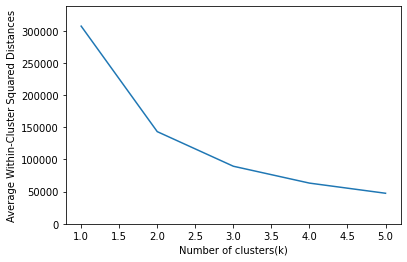

In [53]:
inertia = []
for n_clusters in range(1, 6):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(movie_genre_clusters_df_norm)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(1, 6), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()

In [1160]:
# k means
kmeans_movies = KMeans(n_clusters=4, random_state=0)
movie_genre_clusters_df_norm['cluster'] = kmeans_movies.fit_predict(movie_genre_clusters_df_norm)
# get centroids
centroids = kmeans_movies.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
## add to df
movie_genre_clusters_df_norm['cen_x'] = movie_genre_clusters_df_norm.cluster.map({0:cen_x[0], 
                                                                                  1:cen_x[1], 
                                                                                  2:cen_x[2]})
movie_genre_clusters_df_norm['cen_y'] = movie_genre_clusters_df_norm.cluster.map({0:cen_y[0], 
                                                                                  1:cen_y[1], 
                                                                                  2:cen_y[2]})
# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF']
movie_genre_clusters_df_norm['c'] = movie_genre_clusters_df_norm.cluster.map({0:colors[0], 
                                                                              1:colors[1], 
                                                                              2:colors[2]})

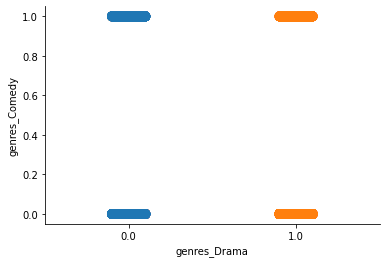

In [1165]:
sns.stripplot(x='genres_Drama',y='genres_Comedy',data=movie_genre_clusters_df, 
            c=movie_genre_clusters_df_norm.c, alpha = 0.1, s=10, jitter=True)
sns.despine()

In [71]:
movie_genre_clusters_df=X[filter_col]
movie_genre_clusters_df['avg_rating']=y[['avg_rating']]
movie_genre_clusters_df.dropna(inplace=True)

In [56]:
movie_genre_clusters_df.head()

,genres_Action,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,genres_Foreign,...,genres_Horror,genres_Music,genres_Mystery,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western,avg_rating
0,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3.89
1,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,3.24
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,3.18
3,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,2.88
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.08


In [57]:
movie_genre_clusters_df = movie_genre_clusters_df.apply(lambda x: x.astype('float64'))

# Normalized distance
movie_genre_clusters_df_norm = movie_genre_clusters_df.apply(preprocessing.scale, axis=0)

In [58]:
kmeans_movies2 = KMeans(n_clusters=4, random_state=0).fit(movie_genre_clusters_df_norm)

# calculate the distances of each data point to the cluster centers
distances_movies = kmeans_movies2.transform(movie_genre_clusters_df_norm)

# reduce to the minimum squared distance of each data 
# point to the cluster centers
minSquaredDistances_movies = distances_movies.min(axis=1) ** 2

# combine with cluster labels into a data frame
df_movies_cluster_centroids = pd.DataFrame({'squaredDistance': minSquaredDistances_movies,
                                            'cluster': kmeans_movies2.labels_},
                                           index=movie_genre_clusters_df_norm.index)

# Group by cluster and print information
for cluster, data in df_movies_cluster_centroids.groupby('cluster'):
    count = len(data)
    withinClustSS_movies = data.squaredDistance.sum()
    print(f'Cluster {cluster} ({count} members): {withinClustSS_movies:.2f} within cluster ')
    

Cluster 0 (4679 members): 53066.77 within cluster 
Cluster 1 (7357 members): 160360.08 within cluster 
Cluster 2 (2611 members): 43300.57 within cluster 
Cluster 3 (714 members): 9706.69 within cluster 


In [59]:
centroids_movies = pd.DataFrame(kmeans_movies2.cluster_centers_, 
                         columns=movie_genre_clusters_df.columns)
print(centroids_movies)


   genres_Action  genres_Adventure  genres_Animation  genres_Comedy  \
0      -0.187380         -0.135687         -0.220788       1.368907   
1       0.118170          0.063744         -0.220788      -0.713518   
2       0.034934         -0.058410         -0.220788      -0.435346   
3      -0.117422          0.445972          4.529239      -0.026713   

   genres_Crime  genres_Documentary  genres_Drama  genres_Family  \
0     -0.134241           -0.189973     -0.262371       0.078787   
1      0.206487            0.211350      0.455051      -0.123598   
2     -0.249160           -0.207378     -0.604812      -0.237719   
3     -0.336771           -0.174446     -0.757718       1.626537   

   genres_Fantasy  genres_Foreign  ...  genres_Horror  genres_Music  \
0       -0.017439       -0.023121  ...      -0.372061      0.115931   
1       -0.063011        0.023850  ...      -0.376331      0.004901   
2        0.147466       -0.017511  ...       1.816178     -0.201375   
3        0.224273  

,genres_Action,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,genres_Foreign,...,genres_Music,genres_Mystery,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western,avg_rating,cluster
0,-0.187380,-0.135687,-0.220788,1.368907,-0.134241,-0.189973,-0.262371,0.078787,-0.017439,-0.023121,...,0.115931,-0.153180,0.341184,-0.238760,-0.063625,-0.374030,-0.107167,-0.114049,0.020331,Cluster 0
1,0.118170,0.063744,-0.220788,-0.713518,0.206487,0.211350,0.455051,-0.123598,-0.063011,0.023850,...,0.004901,0.056046,-0.036010,-0.265223,0.044283,0.100397,0.131990,0.151196,0.211731,Cluster 1
2,0.034934,-0.058410,-0.220788,-0.435346,-0.249160,-0.207378,-0.604812,-0.237719,0.147466,-0.017511,...,-0.201375,0.179351,-0.403244,1.197782,-0.003189,0.505771,-0.139965,-0.174473,-0.677293,Cluster 2
3,-0.117422,0.445972,4.529239,-0.026713,-0.336771,-0.174446,-0.757718,1.626537,0.224273,-0.030203,...,-0.073815,-0.229540,-0.390208,-0.082638,-0.027676,-0.432913,-0.145889,-0.172493,0.161871,Cluster 3


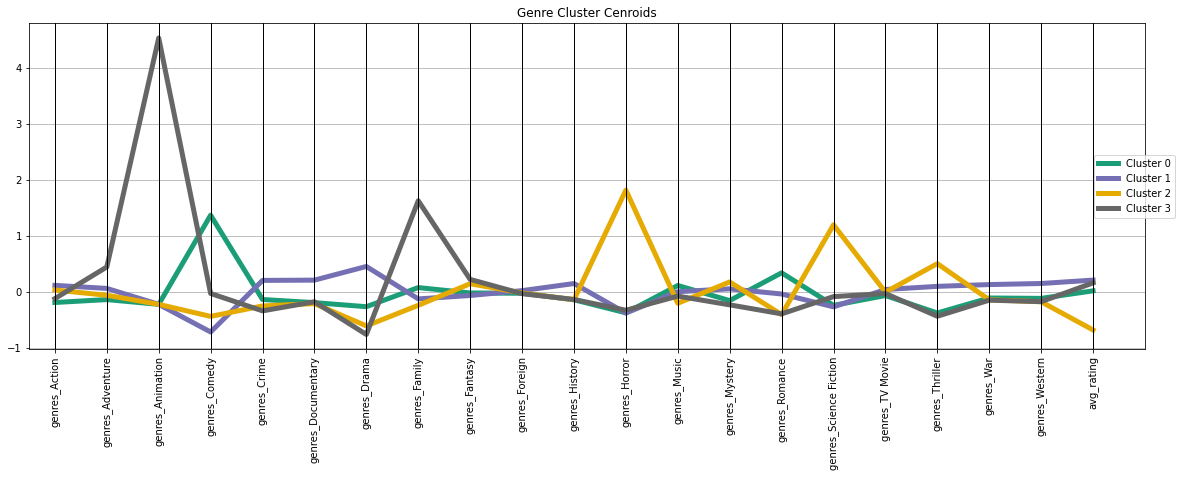

In [60]:
centroids_movies['cluster'] = ['Cluster {}'.format(i) for i in centroids_movies.index]

fig, ax = plt.subplots(figsize=(20,6))
#plt.figure(figsize=(10,6))
#fig.subplots_adjust(right=3)
ax = parallel_coordinates(centroids_movies, class_column='cluster', colormap='Dark2', 
                          linewidth=5)
plt.title('Genre Cluster Cenroids')
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
plt.xlim(-0.5,21)
plt.xticks(rotation=90)
centroids_movies

*Results:*

* Cluster 0 is characterized by a peak in Comedy, and smaller peaks in Family and Romance, with small spacing, but spacing in the average rating
* Cluster 1 is characterized by small peaks in Crime, Documentary, Drama, small peak in History, and mid level in Thriller, War, Western and has similar average rating to Cluster 3.
* Cluster 2 is characterized by noticeable peaks in Horror, Science Fiction and Thriller, with a noticeable separation from the other clusters when it comes to the avg rating.
* Cluster 3 is characterized by a large peak in Animation and Family with similar avg rating as cluster 1

----

-----